<a href="https://colab.research.google.com/github/Quaser001/AD_CBAM/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# CONFIG
T1_DIR = "/content/drive/MyDrive/CycleGan/T1 healthy images/T1 healthy images"
T2_DIR = "/content/drive/MyDrive/CycleGan/T2 Healthy images/T2 Healthy images"
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 2
EPOCHS = 100
OUTPUT_DIR = "/content/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [4]:
# INSTANCE NORMALIZATION
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],), initializer="ones", trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1,2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(variance + self.epsilon) + self.beta


In [5]:
# VGG PERCEPTUAL LOSS
def build_vgg_model():
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
    vgg.trainable = False
    return tf.keras.Model(vgg.input, vgg.get_layer('block3_conv3').output)

vgg_model = build_vgg_model()

def perceptual_loss(y_true, y_pred):
    y_true = (y_true + 1.0) * 127.5
    y_pred = (y_pred + 1.0) * 127.5
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)
    y_true_pre = preprocess_input(y_true_rgb)
    y_pred_pre = preprocess_input(y_pred_rgb)
    real_features = vgg_model(y_true_pre)
    fake_features = vgg_model(y_pred_pre)
    return tf.reduce_mean(tf.abs(real_features - fake_features))

In [6]:
# SHIFTED WINDOW SELF-ATTENTION (Swin-like)
class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size=8, num_heads=4):
        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        assert dim % num_heads == 0
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

    def build(self, input_shape):
        self.qkv = layers.Dense(self.dim*3)
        self.proj = layers.Dense(self.dim)

    def call(self, x):
        B, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]

        pad_h = (self.window_size - H % self.window_size) % self.window_size
        pad_w = (self.window_size - W % self.window_size) % self.window_size
        x = tf.pad(x, [[0,0],[0,pad_h],[0,pad_w],[0,0]])
        H_pad, W_pad = tf.shape(x)[1], tf.shape(x)[2]

        x_windows = tf.image.extract_patches(
            images=x,
            sizes=[1, self.window_size, self.window_size, 1],
            strides=[1, self.window_size, self.window_size,1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        x_windows = tf.reshape(x_windows, [-1, self.window_size*self.window_size, C])

        qkv = self.qkv(x_windows)
        qkv = tf.reshape(qkv, [-1, tf.shape(qkv)[1], 3, self.num_heads, self.head_dim])
        qkv = tf.transpose(qkv, perm=[2,0,3,1,4])
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        out = tf.matmul(attn, v)
        out = tf.transpose(out, perm=[0,2,1,3])
        out = tf.reshape(out, [-1, self.window_size*self.window_size, C])
        out = self.proj(out)

        num_windows = H_pad//self.window_size * W_pad//self.window_size
        out = tf.reshape(out, [-1, H_pad//self.window_size, W_pad//self.window_size, self.window_size, self.window_size, C])
        out = tf.transpose(out, [0,1,3,2,4,5])
        out = tf.reshape(out, [-1, H_pad, W_pad, C])
        return out[:, :H, :W, :]

In [7]:
# Swin Transformer Block
def SwinBlock(x, dim, num_heads, window_size=8, shift_size=0):
    shortcut = x
    x = layers.LayerNormalization()(x)
    x = WindowAttention(dim, window_size, num_heads)(x)
    x = layers.Add()([shortcut, x])
    x = layers.LayerNormalization()(x)
    x = layers.Dense(dim*4, activation='gelu')(x)
    x = layers.Dense(dim)(x)
    x = layers.Add()([shortcut, x])
    return x


In [8]:
def build_generator():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    x = layers.Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)

    # encoder
    filters = [128, 256, 512]
    skips = [x]
    for f in filters:
        x = layers.Conv2D(f, 3, strides=2, padding='same')(x)
        x = InstanceNormalization()(x)
        x = layers.ReLU()(x)
        x = SwinBlock(x, f, num_heads=4)
        skips.append(x)

    x = layers.Conv2D(512, 3, padding='same')(x)
    x = InstanceNormalization()(x)
    x = SwinBlock(x, 512, num_heads=4)

    # decoder
    up_filters = [512, 256, 128, 64]
    for f, skip in zip(up_filters, reversed(skips)):
        if f != 512:
            x = layers.Conv2DTranspose(f, 3, strides=2, padding='same')(x)
            x = InstanceNormalization()(x)
            x = layers.ReLU()(x)
        x = SwinBlock(x, f, num_heads=4)
        x = layers.Concatenate()([x, skip])

    # final up-sample
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.ReLU()(x)
    x = SwinBlock(x, 64, num_heads=4)

    # head
    x = layers.Conv2D(1, 1, padding='same', activation='tanh')(x)
    return Model(inputs, x, name='Generator')

In [9]:
# Discriminator
def build_discriminator():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH,1))
    x = layers.Conv2D(64,4,strides=2,padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)
    for filters in [128,256,512,512,512]:
        x = layers.Conv2D(filters,4,strides=2,padding='same')(x)
        x = InstanceNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(512,4,strides=1,padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(1,4,padding='same')(x)
    return Model(inputs,x,name='Discriminator')


In [10]:
# DATA LOADER
def extract_id(filename):
    parts = filename.split("_")
    for part in parts:
        if part.startswith("slice"):
            return "_".join(parts[0:3]) + "_" + part
    return filename

def load_images(t1_dir,t2_dir):
    t1_files = os.listdir(t1_dir)
    t2_files = os.listdir(t2_dir)
    t1_map = {extract_id(f):f for f in t1_files}
    t2_map = {extract_id(f):f for f in t2_files}
    common_keys = sorted(list(set(t1_map.keys()) & set(t2_map.keys())))
    t1_images, t2_images = [], []
    for key in common_keys:
        try:
            t1 = load_img(os.path.join(t1_dir,t1_map[key]),color_mode='grayscale',target_size=(IMG_HEIGHT,IMG_WIDTH))
            t2 = load_img(os.path.join(t2_dir,t2_map[key]),color_mode='grayscale',target_size=(IMG_HEIGHT,IMG_WIDTH))
            t1 = img_to_array(t1)/127.5 -1.0
            t2 = img_to_array(t2)/127.5 -1.0
            t1_images.append(t1)
            t2_images.append(t2)
        except Exception as e:
            print(f"Skipping {key}: {e}")
    return np.array(t1_images), np.array(t2_images)


In [11]:
# SSIM + PSNR
def evaluate_ssim_psnr(real,generated):
    real = (real+1.0)*127.5
    generated = (generated+1.0)*127.5
    real = real.squeeze()
    generated = generated.squeeze()
    return (ssim(real,generated,data_range=real.max()-real.min()),
            psnr(real,generated,data_range=real.max()-real.min()))


In [12]:
# VISUALIZE
def save_image_grid(t1,fake_t2,real_t2,filename):
    fig, axs = plt.subplots(1,3,figsize=(12,4))
    for i,img in enumerate([t1,fake_t2,real_t2]):
        axs[i].imshow(img.squeeze(),cmap='gray')
        axs[i].axis('off')
    axs[0].set_title("T1 Input")
    axs[1].set_title("Generated T2")
    axs[2].set_title("Real T2")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR,filename))
    plt.close()

In [13]:
# TRAINING SETUP
loss_obj = tf.keras.losses.MeanSquaredError()
LAMBDA = 10
optimizer_g = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
optimizer_f = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
optimizer_dx = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
optimizer_dy = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

@tf.function
def train_step(real_x,real_y,generator_g,generator_f,discriminator_x,discriminator_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x,training=True)
        fake_x = generator_f(real_y,training=True)
        cycled_x = generator_f(fake_y,training=True)
        cycled_y = generator_g(fake_x,training=True)
        same_x = generator_f(real_x,training=True)
        same_y = generator_g(real_y,training=True)
        disc_real_x = discriminator_x(real_x,training=True)
        disc_real_y = discriminator_y(real_y,training=True)
        disc_fake_x = discriminator_x(fake_x,training=True)
        disc_fake_y = discriminator_y(fake_y,training=True)

        gen_g_loss = loss_obj(tf.ones_like(disc_fake_y),disc_fake_y)
        gen_f_loss = loss_obj(tf.ones_like(disc_fake_x),disc_fake_x)
        total_cycle_loss = tf.reduce_mean(tf.abs(real_x-cycled_x))+tf.reduce_mean(tf.abs(real_y-cycled_y))
        id_loss = tf.reduce_mean(tf.abs(real_x-same_x))+tf.reduce_mean(tf.abs(real_y-same_y))
        perc_loss = perceptual_loss(real_y,fake_y)

        total_gen_g = gen_g_loss + LAMBDA*total_cycle_loss + 0.5*LAMBDA*id_loss + 0.5*perc_loss
        total_gen_f = gen_f_loss + LAMBDA*total_cycle_loss + 0.5*LAMBDA*id_loss

        disc_x_loss = loss_obj(tf.ones_like(disc_real_x),disc_real_x)+loss_obj(tf.zeros_like(disc_fake_x),disc_fake_x)
        disc_y_loss = loss_obj(tf.ones_like(disc_real_y),disc_real_y)+loss_obj(tf.zeros_like(disc_fake_y),disc_fake_y)

    optimizer_g.apply_gradients(zip(tape.gradient(total_gen_g,generator_g.trainable_variables),generator_g.trainable_variables))
    optimizer_f.apply_gradients(zip(tape.gradient(total_gen_f,generator_f.trainable_variables),generator_f.trainable_variables))
    optimizer_dx.apply_gradients(zip(tape.gradient(disc_x_loss,discriminator_x.trainable_variables),discriminator_x.trainable_variables))
    optimizer_dy.apply_gradients(zip(tape.gradient(disc_y_loss,discriminator_y.trainable_variables),discriminator_y.trainable_variables))

In [14]:
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

In [15]:
x_test = tf.random.normal((4, 256, 256, 1))
print('g out:', generator_g(x_test).shape)
print('f out:', generator_f(x_test).shape)

g out: (4, 256, 256, 1)
f out: (4, 256, 256, 1)


In [17]:
# Main
# Reproducibility
SEED = 42
import os, random, numpy as np, tensorflow as tf
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Constants
# T1_DIR, T2_DIR, BATCH_SIZE, EPOCHS, OUTPUT_DIR, IMG_HEIGHT, IMG_WIDTH
CSV_LOG = os.path.join(OUTPUT_DIR, 'metrics.csv')
os.makedirs(OUTPUT_DIR, exist_ok=True)
with open(CSV_LOG, 'w') as f:
    f.write('epoch,train_ssim,train_psnr,val_ssim,val_psnr\n')

t1_imgs, t2_imgs = load_images(T1_DIR, T2_DIR)
print(f'Loaded {len(t1_imgs)} image pairs')

t1_train, t1_val, t2_train, t2_val = train_test_split(
        t1_imgs, t2_imgs, test_size=0.15, random_state=SEED)

n_train = len(t1_train)
n_val   = len(t1_val)
train_steps = n_train // BATCH_SIZE
val_steps   = n_val   // BATCH_SIZE

def metrics_on_batch(imgs, reals):

    fake = generator_g(imgs, training=False).numpy()
    reals = reals.numpy()
    ss, ps = [], []
    for r, f in zip(reals, fake):
        s, p = evaluate_ssim_psnr(r.squeeze(), f.squeeze())
        ss.append(s); ps.append(p)
    return np.mean(ss), np.mean(ps)

for epoch in range(1, EPOCHS + 1):
    print(f'\nEpoch {epoch}/{EPOCHS}')

    train_ss, train_ps = [], []
    for step in tqdm(range(train_steps), desc='Train'):
        idx  = step * BATCH_SIZE
        t1_b = tf.cast(t1_train[idx:idx+BATCH_SIZE], tf.float32)
        t2_b = tf.cast(t2_train[idx:idx+BATCH_SIZE], tf.float32)

        train_step(t1_b, t2_b, generator_g, generator_f,
                   discriminator_x, discriminator_y)

        if step % 10 == 0:
            ss, ps = metrics_on_batch(t1_b, t2_b)
            train_ss.append(ss); train_ps.append(ps)

    val_ss, val_ps = [], []
    for step in tqdm(range(val_steps), desc='Val  '):
        idx  = step * BATCH_SIZE
        t1_b = tf.cast(t1_val[idx:idx+BATCH_SIZE], tf.float32)
        t2_b = tf.cast(t2_val[idx:idx+BATCH_SIZE], tf.float32)

        ss, ps = metrics_on_batch(t1_b, t2_b)
        val_ss.append(ss); val_ps.append(ps)

    tr_ss, tr_ps = np.mean(train_ss), np.mean(train_ps)
    vl_ss, vl_ps = np.mean(val_ss),  np.mean(val_ps)
    print(f'Train  SSIM: {tr_ss:.4f}  PSNR: {tr_ps:.2f} dB')
    print(f'Val    SSIM: {vl_ss:.4f}  PSNR: {vl_ps:.2f} dB')
    with open(CSV_LOG, 'a') as f:
        f.write(f'{epoch},{tr_ss},{tr_ps},{vl_ss},{vl_ps}\n')

print('Training complete – metrics saved to', CSV_LOG)

Loaded 28 image pairs

Epoch 1/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


Train  SSIM: -0.0021  PSNR: 3.06 dB
Val    SSIM: -0.0065  PSNR: 2.55 dB

Epoch 2/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Train  SSIM: -0.0031  PSNR: 2.79 dB
Val    SSIM: -0.0063  PSNR: 2.58 dB

Epoch 3/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Train  SSIM: -0.0033  PSNR: 2.83 dB
Val    SSIM: -0.0059  PSNR: 2.61 dB

Epoch 4/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]


Train  SSIM: -0.0044  PSNR: 2.82 dB
Val    SSIM: -0.0061  PSNR: 2.62 dB

Epoch 5/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Train  SSIM: -0.0045  PSNR: 2.83 dB
Val    SSIM: -0.0062  PSNR: 2.64 dB

Epoch 6/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


Train  SSIM: -0.0062  PSNR: 2.80 dB
Val    SSIM: -0.0060  PSNR: 2.60 dB

Epoch 7/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


Train  SSIM: -0.0048  PSNR: 2.87 dB
Val    SSIM: -0.0051  PSNR: 2.66 dB

Epoch 8/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Train  SSIM: -0.0051  PSNR: 2.88 dB
Val    SSIM: -0.0043  PSNR: 2.64 dB

Epoch 9/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Train  SSIM: -0.0019  PSNR: 2.91 dB
Val    SSIM: -0.0032  PSNR: 2.70 dB

Epoch 10/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


Train  SSIM: -0.0023  PSNR: 2.92 dB
Val    SSIM: -0.0038  PSNR: 2.68 dB

Epoch 11/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


Train  SSIM: -0.0024  PSNR: 2.93 dB
Val    SSIM: -0.0047  PSNR: 2.67 dB

Epoch 12/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Train  SSIM: -0.0036  PSNR: 2.91 dB
Val    SSIM: -0.0045  PSNR: 2.68 dB

Epoch 13/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


Train  SSIM: -0.0014  PSNR: 2.98 dB
Val    SSIM: -0.0033  PSNR: 2.76 dB

Epoch 14/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]


Train  SSIM: -0.0010  PSNR: 2.97 dB
Val    SSIM: -0.0031  PSNR: 2.73 dB

Epoch 15/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


Train  SSIM: -0.0003  PSNR: 3.02 dB
Val    SSIM: -0.0024  PSNR: 2.79 dB

Epoch 16/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Train  SSIM: 0.0009  PSNR: 3.02 dB
Val    SSIM: -0.0027  PSNR: 2.74 dB

Epoch 17/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]


Train  SSIM: -0.0009  PSNR: 3.03 dB
Val    SSIM: -0.0015  PSNR: 2.84 dB

Epoch 18/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Train  SSIM: 0.0023  PSNR: 3.07 dB
Val    SSIM: -0.0011  PSNR: 2.79 dB

Epoch 19/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Train  SSIM: 0.0009  PSNR: 3.08 dB
Val    SSIM: -0.0006  PSNR: 2.87 dB

Epoch 20/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


Train  SSIM: 0.0050  PSNR: 3.16 dB
Val    SSIM: 0.0003  PSNR: 2.90 dB

Epoch 21/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Train  SSIM: 0.0037  PSNR: 3.20 dB
Val    SSIM: 0.0002  PSNR: 2.96 dB

Epoch 22/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]


Train  SSIM: 0.0024  PSNR: 3.18 dB
Val    SSIM: -0.0003  PSNR: 2.96 dB

Epoch 23/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Train  SSIM: 0.0020  PSNR: 3.15 dB
Val    SSIM: 0.0026  PSNR: 2.96 dB

Epoch 24/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


Train  SSIM: 0.1590  PSNR: 7.20 dB
Val    SSIM: 0.3570  PSNR: 11.36 dB

Epoch 25/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Train  SSIM: 0.3468  PSNR: 11.06 dB
Val    SSIM: 0.3727  PSNR: 11.43 dB

Epoch 26/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Train  SSIM: 0.3502  PSNR: 11.04 dB
Val    SSIM: 0.3797  PSNR: 11.49 dB

Epoch 27/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


Train  SSIM: 0.3553  PSNR: 11.14 dB
Val    SSIM: 0.3806  PSNR: 11.30 dB

Epoch 28/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


Train  SSIM: 0.3663  PSNR: 12.09 dB
Val    SSIM: 0.3999  PSNR: 13.57 dB

Epoch 29/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Train  SSIM: 0.3754  PSNR: 12.94 dB
Val    SSIM: 0.3983  PSNR: 13.60 dB

Epoch 30/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


Train  SSIM: 0.3926  PSNR: 13.49 dB
Val    SSIM: 0.4189  PSNR: 14.48 dB

Epoch 31/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]


Train  SSIM: 0.4586  PSNR: 15.36 dB
Val    SSIM: 0.4872  PSNR: 17.03 dB

Epoch 32/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Train  SSIM: 0.4933  PSNR: 16.30 dB
Val    SSIM: 0.5080  PSNR: 17.36 dB

Epoch 33/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Train  SSIM: 0.5589  PSNR: 17.23 dB
Val    SSIM: 0.5511  PSNR: 17.87 dB

Epoch 34/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Train  SSIM: 0.5899  PSNR: 17.72 dB
Val    SSIM: 0.5527  PSNR: 17.83 dB

Epoch 35/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Train  SSIM: 0.5956  PSNR: 17.95 dB
Val    SSIM: 0.5583  PSNR: 17.96 dB

Epoch 36/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Train  SSIM: 0.6162  PSNR: 18.13 dB
Val    SSIM: 0.5583  PSNR: 17.97 dB

Epoch 37/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Train  SSIM: 0.6341  PSNR: 18.55 dB
Val    SSIM: 0.5645  PSNR: 18.11 dB

Epoch 38/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Train  SSIM: 0.6610  PSNR: 19.11 dB
Val    SSIM: 0.5663  PSNR: 18.14 dB

Epoch 39/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Train  SSIM: 0.6803  PSNR: 19.51 dB
Val    SSIM: 0.5557  PSNR: 17.75 dB

Epoch 40/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Train  SSIM: 0.6439  PSNR: 19.27 dB
Val    SSIM: 0.5108  PSNR: 17.63 dB

Epoch 41/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Train  SSIM: 0.6658  PSNR: 19.18 dB
Val    SSIM: 0.5737  PSNR: 18.04 dB

Epoch 42/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Train  SSIM: 0.7213  PSNR: 20.45 dB
Val    SSIM: 0.5710  PSNR: 17.99 dB

Epoch 43/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


Train  SSIM: 0.7307  PSNR: 20.55 dB
Val    SSIM: 0.5718  PSNR: 18.13 dB

Epoch 44/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Train  SSIM: 0.7378  PSNR: 20.89 dB
Val    SSIM: 0.5902  PSNR: 18.16 dB

Epoch 45/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Train  SSIM: 0.7595  PSNR: 21.20 dB
Val    SSIM: 0.5796  PSNR: 18.10 dB

Epoch 46/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Train  SSIM: 0.7654  PSNR: 21.46 dB
Val    SSIM: 0.5662  PSNR: 18.07 dB

Epoch 47/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Train  SSIM: 0.7691  PSNR: 21.32 dB
Val    SSIM: 0.5940  PSNR: 18.43 dB

Epoch 48/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]


Train  SSIM: 0.7917  PSNR: 21.88 dB
Val    SSIM: 0.5831  PSNR: 18.14 dB

Epoch 49/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Train  SSIM: 0.8009  PSNR: 22.37 dB
Val    SSIM: 0.5768  PSNR: 18.09 dB

Epoch 50/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


Train  SSIM: 0.7898  PSNR: 22.32 dB
Val    SSIM: 0.5733  PSNR: 18.23 dB

Epoch 51/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


Train  SSIM: 0.7866  PSNR: 22.52 dB
Val    SSIM: 0.5719  PSNR: 17.83 dB

Epoch 52/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Train  SSIM: 0.8159  PSNR: 23.15 dB
Val    SSIM: 0.5811  PSNR: 17.43 dB

Epoch 53/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


Train  SSIM: 0.8111  PSNR: 22.84 dB
Val    SSIM: 0.5829  PSNR: 18.40 dB

Epoch 54/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


Train  SSIM: 0.8226  PSNR: 23.07 dB
Val    SSIM: 0.5832  PSNR: 18.05 dB

Epoch 55/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


Train  SSIM: 0.8037  PSNR: 23.29 dB
Val    SSIM: 0.5578  PSNR: 17.97 dB

Epoch 56/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Train  SSIM: 0.8073  PSNR: 23.37 dB
Val    SSIM: 0.5831  PSNR: 17.88 dB

Epoch 57/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


Train  SSIM: 0.8380  PSNR: 23.73 dB
Val    SSIM: 0.5944  PSNR: 18.30 dB

Epoch 58/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]


Train  SSIM: 0.8367  PSNR: 23.29 dB
Val    SSIM: 0.6023  PSNR: 18.70 dB

Epoch 59/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Train  SSIM: 0.8458  PSNR: 23.68 dB
Val    SSIM: 0.5908  PSNR: 18.09 dB

Epoch 60/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Train  SSIM: 0.8459  PSNR: 23.84 dB
Val    SSIM: 0.5830  PSNR: 18.13 dB

Epoch 61/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Train  SSIM: 0.8470  PSNR: 23.93 dB
Val    SSIM: 0.5885  PSNR: 18.23 dB

Epoch 62/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]


Train  SSIM: 0.8530  PSNR: 24.24 dB
Val    SSIM: 0.5842  PSNR: 17.45 dB

Epoch 63/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Train  SSIM: 0.8599  PSNR: 24.42 dB
Val    SSIM: 0.5960  PSNR: 17.96 dB

Epoch 64/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Train  SSIM: 0.8633  PSNR: 24.36 dB
Val    SSIM: 0.6027  PSNR: 18.26 dB

Epoch 65/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Train  SSIM: 0.8655  PSNR: 24.38 dB
Val    SSIM: 0.6085  PSNR: 18.32 dB

Epoch 66/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Train  SSIM: 0.8674  PSNR: 24.41 dB
Val    SSIM: 0.6049  PSNR: 18.57 dB

Epoch 67/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


Train  SSIM: 0.8699  PSNR: 24.38 dB
Val    SSIM: 0.5988  PSNR: 18.47 dB

Epoch 68/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Train  SSIM: 0.8598  PSNR: 24.59 dB
Val    SSIM: 0.5765  PSNR: 17.80 dB

Epoch 69/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


Train  SSIM: 0.8660  PSNR: 24.56 dB
Val    SSIM: 0.6089  PSNR: 18.07 dB

Epoch 70/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


Train  SSIM: 0.8752  PSNR: 25.00 dB
Val    SSIM: 0.6073  PSNR: 18.38 dB

Epoch 71/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


Train  SSIM: 0.8762  PSNR: 24.68 dB
Val    SSIM: 0.5981  PSNR: 18.37 dB

Epoch 72/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Train  SSIM: 0.8750  PSNR: 24.92 dB
Val    SSIM: 0.5967  PSNR: 18.46 dB

Epoch 73/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


Train  SSIM: 0.8759  PSNR: 24.90 dB
Val    SSIM: 0.5967  PSNR: 18.31 dB

Epoch 74/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


Train  SSIM: 0.8763  PSNR: 25.15 dB
Val    SSIM: 0.5910  PSNR: 17.86 dB

Epoch 75/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


Train  SSIM: 0.8786  PSNR: 25.13 dB
Val    SSIM: 0.6082  PSNR: 18.32 dB

Epoch 76/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Train  SSIM: 0.8654  PSNR: 24.92 dB
Val    SSIM: 0.5844  PSNR: 18.36 dB

Epoch 77/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


Train  SSIM: 0.8664  PSNR: 25.12 dB
Val    SSIM: 0.6019  PSNR: 18.26 dB

Epoch 78/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Train  SSIM: 0.8822  PSNR: 25.59 dB
Val    SSIM: 0.5963  PSNR: 17.99 dB

Epoch 79/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Train  SSIM: 0.8812  PSNR: 25.56 dB
Val    SSIM: 0.5995  PSNR: 18.27 dB

Epoch 80/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Train  SSIM: 0.8856  PSNR: 25.55 dB
Val    SSIM: 0.6045  PSNR: 18.08 dB

Epoch 81/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


Train  SSIM: 0.8868  PSNR: 25.82 dB
Val    SSIM: 0.6033  PSNR: 18.14 dB

Epoch 82/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Train  SSIM: 0.8867  PSNR: 25.83 dB
Val    SSIM: 0.5991  PSNR: 18.11 dB

Epoch 83/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


Train  SSIM: 0.8777  PSNR: 25.93 dB
Val    SSIM: 0.5922  PSNR: 17.83 dB

Epoch 84/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


Train  SSIM: 0.8817  PSNR: 25.82 dB
Val    SSIM: 0.5967  PSNR: 18.24 dB

Epoch 85/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Train  SSIM: 0.8886  PSNR: 26.03 dB
Val    SSIM: 0.5983  PSNR: 18.10 dB

Epoch 86/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


Train  SSIM: 0.8881  PSNR: 25.81 dB
Val    SSIM: 0.5968  PSNR: 17.72 dB

Epoch 87/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


Train  SSIM: 0.8911  PSNR: 25.90 dB
Val    SSIM: 0.6077  PSNR: 18.07 dB

Epoch 88/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]


Train  SSIM: 0.8906  PSNR: 26.22 dB
Val    SSIM: 0.6049  PSNR: 18.03 dB

Epoch 89/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


Train  SSIM: 0.8897  PSNR: 26.17 dB
Val    SSIM: 0.6047  PSNR: 18.30 dB

Epoch 90/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


Train  SSIM: 0.8920  PSNR: 26.77 dB
Val    SSIM: 0.5975  PSNR: 17.81 dB

Epoch 91/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Train  SSIM: 0.8919  PSNR: 26.16 dB
Val    SSIM: 0.5928  PSNR: 17.63 dB

Epoch 92/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]


Train  SSIM: 0.8960  PSNR: 26.65 dB
Val    SSIM: 0.6048  PSNR: 17.58 dB

Epoch 93/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]


Train  SSIM: 0.8955  PSNR: 26.61 dB
Val    SSIM: 0.6102  PSNR: 18.12 dB

Epoch 94/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


Train  SSIM: 0.8830  PSNR: 26.58 dB
Val    SSIM: 0.5902  PSNR: 17.92 dB

Epoch 95/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


Train  SSIM: 0.8930  PSNR: 26.94 dB
Val    SSIM: 0.6016  PSNR: 17.68 dB

Epoch 96/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Train  SSIM: 0.8954  PSNR: 26.99 dB
Val    SSIM: 0.6008  PSNR: 17.77 dB

Epoch 97/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Train  SSIM: 0.8940  PSNR: 25.76 dB
Val    SSIM: 0.6093  PSNR: 18.57 dB

Epoch 98/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]


Train  SSIM: 0.8986  PSNR: 27.03 dB
Val    SSIM: 0.6090  PSNR: 17.92 dB

Epoch 99/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


Train  SSIM: 0.8964  PSNR: 26.40 dB
Val    SSIM: 0.6038  PSNR: 17.84 dB

Epoch 100/100


Val  : 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


Train  SSIM: 0.8933  PSNR: 27.08 dB
Val    SSIM: 0.5946  PSNR: 17.82 dB
Training complete – metrics saved to /content/output/metrics.csv


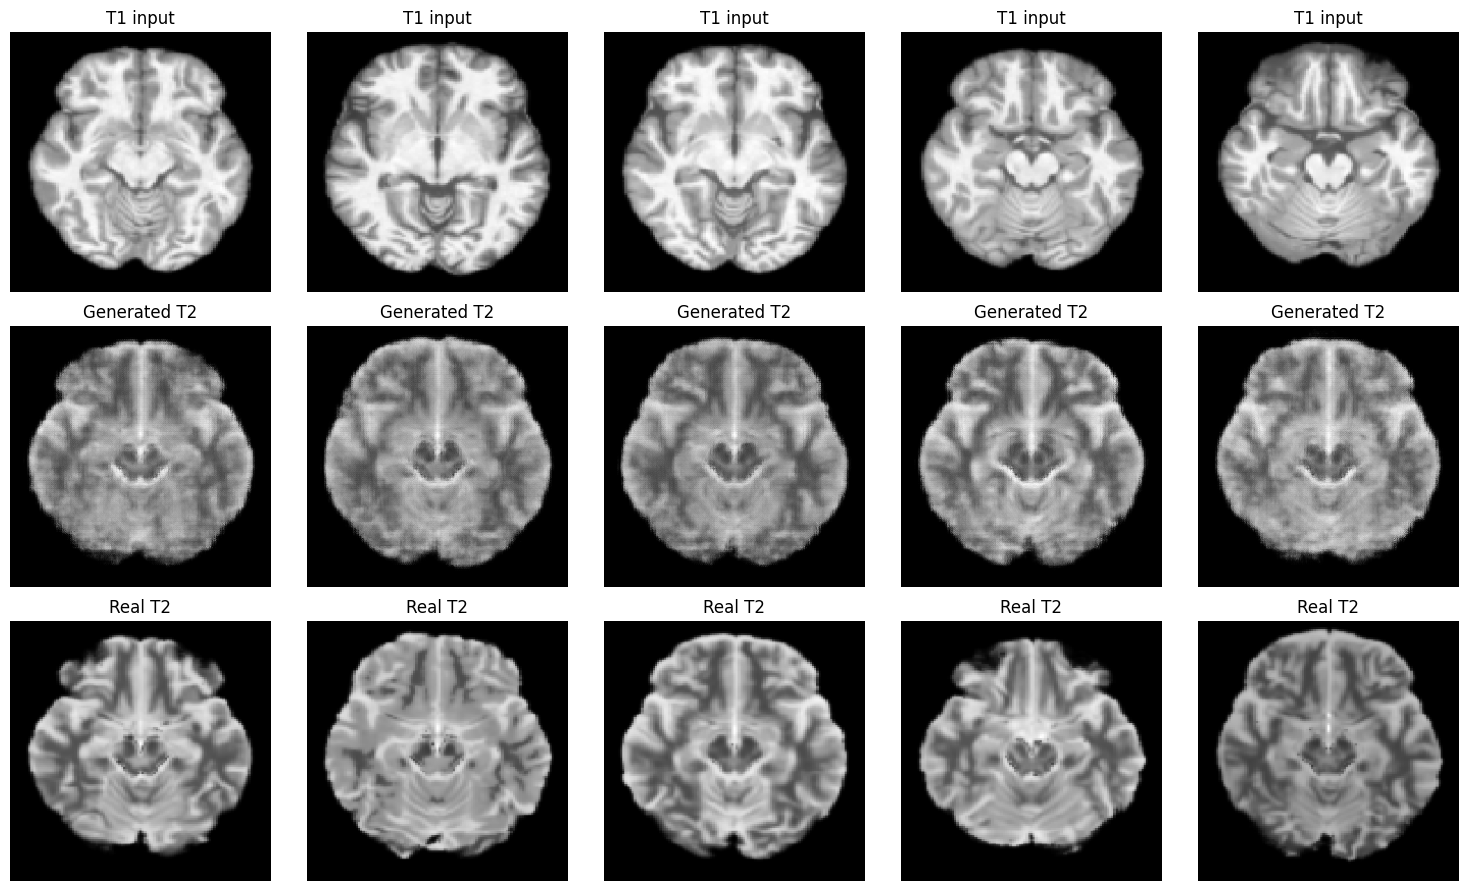

In [22]:
# Results
import matplotlib.pyplot as plt
n_show = min(5, len(t1_val))   # never exceed available val pairs
fig, axes = plt.subplots(3, n_show, figsize=(3 * n_show, 9))
for col in range(n_show):
    t1      = t1_val[col]
    t2_real = t2_val[col]
    t2_fake = generator_g(np.expand_dims(t1, 0), training=False)[0].numpy()

    axes[0, col].imshow(t1.squeeze(),      cmap='gray'); axes[0, col].set_title('T1 input')
    axes[1, col].imshow(t2_fake.squeeze(), cmap='gray'); axes[1, col].set_title('Generated T2')
    axes[2, col].imshow(t2_real.squeeze(), cmap='gray'); axes[2, col].set_title('Real T2')
    for ax in axes[:, col]: ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'final_grid.png'), dpi=300)
plt.show()

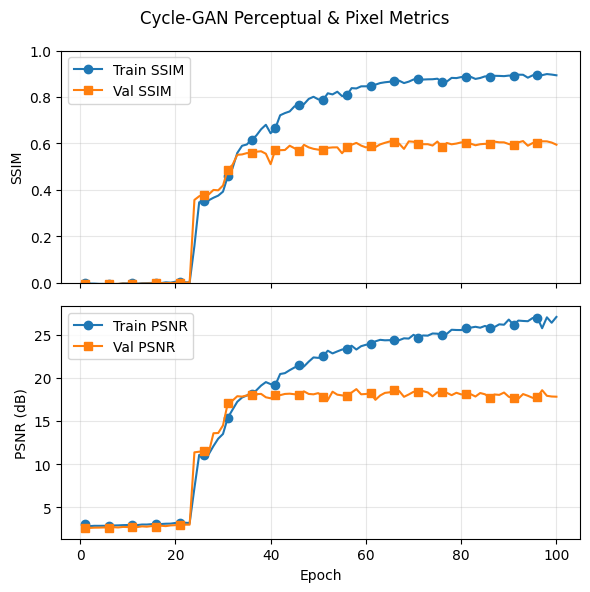

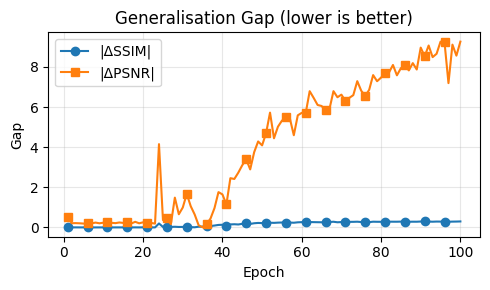

90 % of best Val-SSIM reached at epoch 33  (best = 0.610)


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = os.path.join(OUTPUT_DIR, 'metrics.csv')
df = pd.read_csv(csv_path)


# 1. SSIM & PSNR  –  perceptual + pixel fidelity

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

ax1.plot(df.epoch, df.train_ssim, label='Train SSIM', marker='o', markevery=5)
ax1.plot(df.epoch, df.val_ssim,   label='Val SSIM',  marker='s', markevery=5)
ax1.set_ylabel('SSIM'); ax1.legend(); ax1.grid(alpha=.3)
ax1.set_ylim(0, 1)

ax2.plot(df.epoch, df.train_psnr, label='Train PSNR', marker='o', markevery=5)
ax2.plot(df.epoch, df.val_psnr,   label='Val PSNR',  marker='s', markevery=5)
ax2.set_ylabel('PSNR (dB)'); ax2.legend(); ax2.grid(alpha=.3)
ax2.set_xlabel('Epoch')

plt.suptitle('Cycle-GAN Perceptual & Pixel Metrics')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'eval_curves_ssim_psnr.pdf'))
plt.savefig(os.path.join(OUTPUT_DIR, 'eval_curves_ssim_psnr.png'), dpi=300)
plt.show()


# 2.  Generalisation gap

gap_ssim = np.abs(df.train_ssim - df.val_ssim)
gap_psnr = np.abs(df.train_psnr - df.val_psnr)

plt.figure(figsize=(5, 3))
plt.plot(df.epoch, gap_ssim, label='|ΔSSIM|', marker='o', markevery=5)
plt.plot(df.epoch, gap_psnr, label='|ΔPSNR|', marker='s', markevery=5)
plt.ylabel('Gap'); plt.xlabel('Epoch'); plt.legend(); plt.grid(alpha=.3)
plt.title('Generalisation Gap (lower is better)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'generalisation_gap.pdf'))
plt.show()

# 3.  Convergence speed

best_ssim = df.val_ssim.max()
thresh = 0.9 * best_ssim
epoch_90 = df[df.val_ssim >= thresh].epoch.min()
print(f'90 % of best Val-SSIM reached at epoch {epoch_90}  (best = {best_ssim:.3f})')


In [27]:
#Save Weights
PERMANENT_DIR = '/content/drive/MyDrive/CycleGan_T1T2'
os.makedirs(PERMANENT_DIR, exist_ok=True)

# ----  weights  ----
!cp -r $OUTPUT_DIR/weights $PERMANENT_DIR/

# ----  CSV log  ----
!cp $OUTPUT_DIR/metrics.csv $PERMANENT_DIR/

# ----  curves / grids  ----
!cp $OUTPUT_DIR/*.pdf $PERMANENT_DIR/ 2>/dev/null || true
!cp $OUTPUT_DIR/*.png $PERMANENT_DIR/ 2>/dev/null || true

print('✅  All artefacts copied to Drive:', PERMANENT_DIR)

✅  All artefacts copied to Drive: /content/drive/MyDrive/CycleGan_T1T2
